In [1]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import ticker
import geostatspy.geostats as geostats 
import skgstat as skg
from skgstat import models
import GStatSim as gs
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from sklearn.cluster import KMeans
from skimage.io import imread
from skimage.filters import gaussian

(2000, 2000)


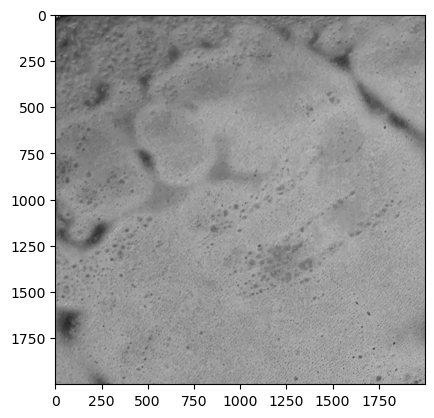

In [2]:
gray = imread('pancake2.jpg', as_gray=True)
gray = gray[:2000,:2000]
print(gray.shape)

plt.imshow(gray, cmap='gray')
plt.show()

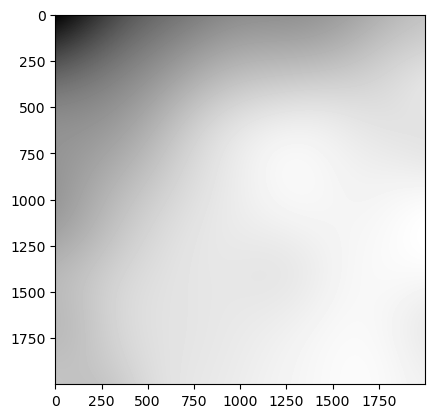

In [3]:
gau = gaussian(gray, 200)
plt.imshow(gau, cmap='gray')
plt.show()

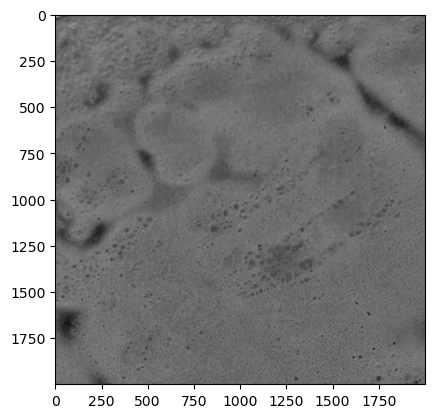

In [4]:
res = gray - gau
plt.imshow(res, cmap='gray')
plt.show()

In [5]:
x = np.arange(res.shape[1])
y = np.arange(res.shape[0])

xx, yy = np.meshgrid(x, y)
print(xx.shape, yy.shape)

(2000, 2000) (2000, 2000)


In [6]:
data = np.dstack([xx, yy, res]).reshape(x.shape[0]*y.shape[0],3)
df = pd.DataFrame(data=data, columns=['X', 'Y', 'Z'])

In [7]:
# generate n random indices

n_points = 300

rng = default_rng()
ridxs = rng.choice(df.shape[0], n_points)

df_samp = df.iloc[ridxs]

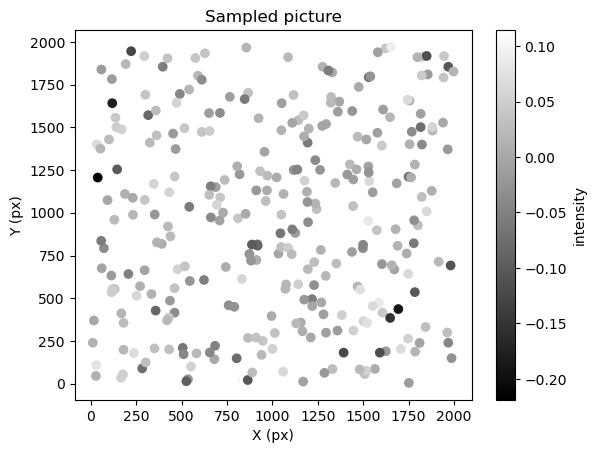

In [8]:
plt.scatter(df_samp.X, df_samp.Y, c=df_samp.Z, cmap='gray')
plt.colorbar(label='intensity')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.title('Sampled picture')
plt.show()

/var/folders/c6/6zp8m7kx6wb85gngswh9tzwc0000gp/T/ipykernel_98670/908843330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samp['Nscore'], tvbed, tnsbed = geostats.nscore(df_samp,'Z')


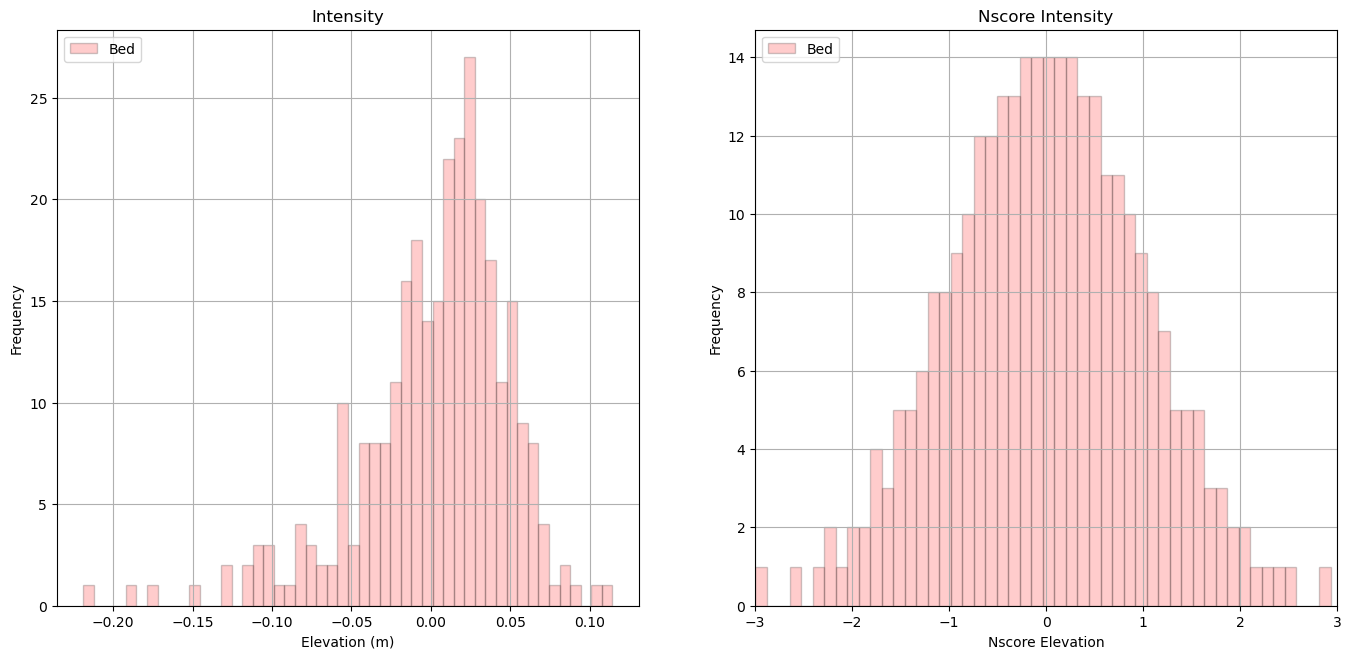

In [9]:
df_samp['Nscore'], tvbed, tnsbed = geostats.nscore(df_samp,'Z')

plt.subplot(121)                                        # plot original bed histogram
plt.hist(df_samp['Z'], facecolor='red',bins=50,alpha=0.2,edgecolor='black',label='Bed')
plt.xlabel('Elevation (m)'); plt.ylabel('Frequency'); plt.title('Intensity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)                                        # plot normal score bed histogram (with weights)
plt.hist(df_samp['Nscore'], facecolor='red',bins=50,alpha=0.2,edgecolor='black',label='Bed')
plt.xlim([-3.0,3.0]); 
plt.xlabel('Nscore Elevation'); plt.ylabel('Frequency'); plt.title('Nscore Intensity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

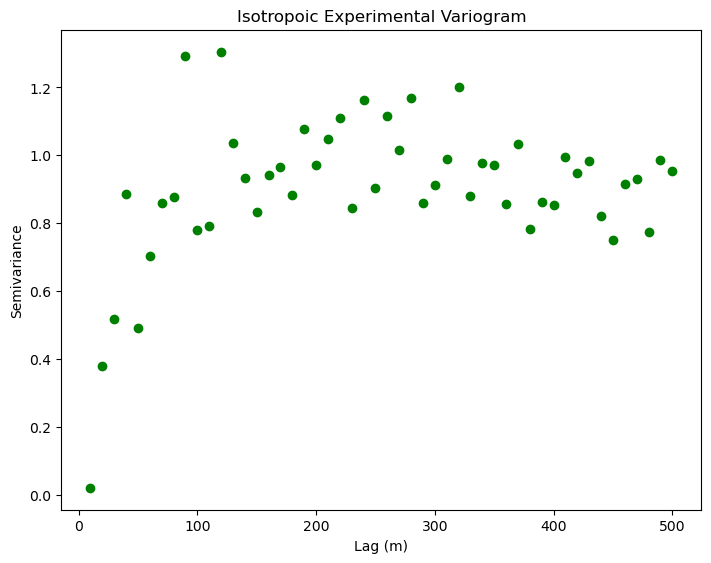

In [10]:
# compute experimental (isotropic) variogram
coords = df_samp[['X','Y']].values
values = df_samp['Nscore']

maxlag = 500 # maximum range distance
n_lags = 50 #num of bins

# compute variogram
V0 = skg.Variogram(coords, values, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

# extract variogram values
xdata = V0.bins
ydata = V0.experimental

plt.plot(xdata,ydata,'og')
plt.title('Isotropoic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1) # adjust the plot size

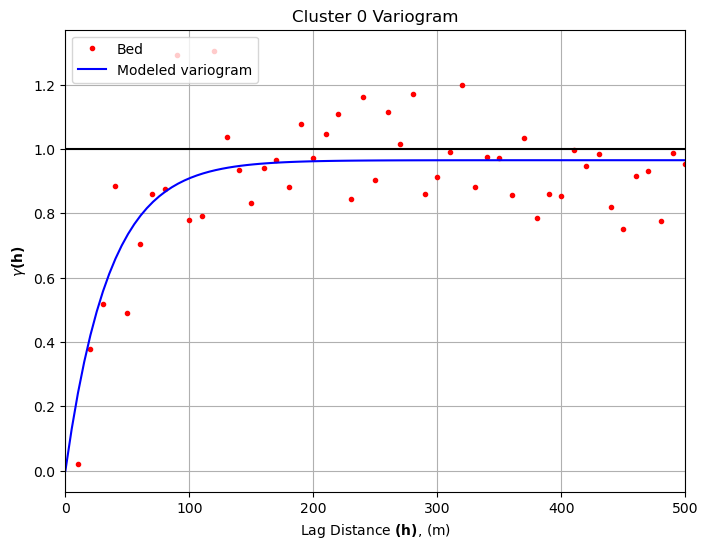

In [11]:
V0.model = 'exponential'

# fit variogram model

V0.model = 'exponential' # use exponential variogram model

n = 100
lagh = np.linspace(0,500,n) # create array of evenly spaced lag values to evaluate

range0 = V0.parameters[0]; sill0 = V0.parameters[1]

y0 = [models.exponential(h, range0, sill0, 0) for h in lagh]

plt.figure(figsize=(8,6))
plt.plot(V0.bins,V0.experimental,'.',color = 'red',label = 'Bed')
plt.plot(lagh,y0,'-',color = 'blue',label = 'Modeled variogram')
plt.plot([0,500],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Cluster 0 Variogram')
plt.legend(loc='upper left')
plt.grid(True)
plt.xlim([0,500])
plt.show()

In [12]:
# define coordinate grid
res = 10
xmin = np.min(df_samp['X']); xmax = np.max(df_samp['X'])     # min and max x values
ymin = np.min(df_samp['Y']); ymax = np.max(df_samp['Y'])     # min and max y values

Pred_grid_xy = gs.pred_grid(xmin, xmax, ymin, ymax, res)

In [13]:
df_samp.shape

(300, 4)

In [25]:
# set variogram parameters
Azimuth = 0
nug = V0.parameters[2]
# the major and minor ranges are the same in this example because it is isotropic
a_maj = V0.parameters[0]
a_min = V0.parameters[0]
sill = 1 # we recommend using a sill of 1, rather than the sill from the variogram model fit
vario = [Azimuth, nug, a_maj, a_min, sill] # save variogram parameters as a list

k = 48 # number of neighboring data points used to estimate a given point 
rad = 1000 # 50 km search radius

sim = gs.okrige_SGS(Pred_grid_xy, df_samp, 'X', 'Y', 'Nbed', k, vario, rad) 

100%|████████████████████████████████████████████████| 39600/39600 [03:59<00:00, 165.51it/s]


In [26]:
Pred_grid_xy.shape

(39600, 2)

In [27]:
# reverse normal score transformation
df_sim= pd.DataFrame(sim, columns = ['sim'])

# transformation parameters
vr = tvbed; vrg = tnsbed; ltail = 1; utail = 1; zmin = -4; zmax = 4; ltpar = -1500; utpar = 1500

# transformation
sim_trans = geostats.backtr(df_sim,'sim',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

(-88.5, 2100.5, -93.5, 2073.5)

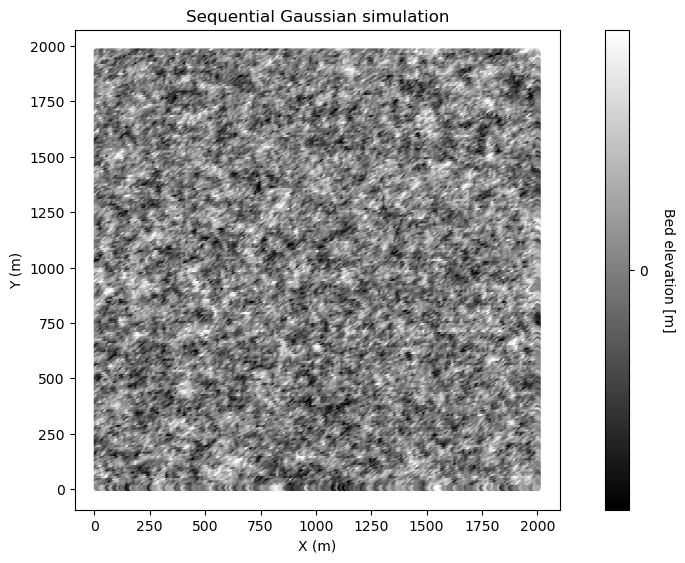

In [30]:
# plot simulation

im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = sim, vmin = -3, vmax = 3, marker=".", s = 50,
                cmap = 'gray')       # scatter plot for location map
plt.title('Sequential Gaussian simulation')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

In [22]:
np.sqrt(sim_trans.shape[0])

198.997487421324

In [24]:
sim_trans.shape

(39600,)

In [18]:
d = sim_trans.reshape((21,21))

ValueError: cannot reshape array of size 39600 into shape (21,21)

In [ ]:
plt.imshow(d, cmap='gray')
plt.show()